In [66]:
import os
import mlflow
import numpy as np
import pandas as pd

from math import sqrt
from joblib import delayed
from joblib import Parallel

from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import pyplot
import matplotlib.dates as mdates

from pathlib import Path
from functools import reduce
from datetime import datetime

from prophet import Prophet

import random
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from regressors import stats
from mlxtend.feature_selection import SequentialFeatureSelector as sfs


## Load data

In [67]:
df = pd.read_csv('./../error_dfs/error_2018_2019_nn.csv', converters={'ags2': str, 'ags5': str} )

In [68]:
# fix ags5 missing 0 
df['ags5'] = np.where(df.ags5.str.len() ==4, '0' + df['ags5'], df['ags5'])

In [69]:
# add 'ags2','bundesland','kreis'
df2 = pd.read_csv('./../corona_data_sets/oeffentliche_finanzen.csv', converters={'ags2': str, 'ags5': str} )
df = pd.merge(df, df2[['ags2','ags5','bundesland','kreis']])
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df

,ags5,date,ground_truth,pred,error,ags2,bundesland,kreis
0,01001,2018-01-31,9.3,8.666405,0.633595,01,Schleswig-Holstein,"Flensburg, Stadt"
1,01001,2018-02-28,9.2,8.807995,0.392005,01,Schleswig-Holstein,"Flensburg, Stadt"
2,01001,2018-03-31,9.1,8.730574,0.369426,01,Schleswig-Holstein,"Flensburg, Stadt"
3,01001,2018-04-30,8.8,8.242456,0.557545,01,Schleswig-Holstein,"Flensburg, Stadt"
4,01001,2018-05-31,8.3,8.107006,0.192994,01,Schleswig-Holstein,"Flensburg, Stadt"
...,...,...,...,...,...,...,...,...
9619,16077,2019-08-31,7.0,7.114399,0.114399,16,Thüringen,Altenburger Land
9620,16077,2019-09-30,6.5,7.089566,0.589566,16,Thüringen,Altenburger Land
9621,16077,2019-10-31,6.5,6.721840,0.221840,16,Thüringen,Altenburger Land
9622,16077,2019-11-30,6.3,6.756373,0.456373,16,Thüringen,Altenburger Land


In [70]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

## Plot each variable

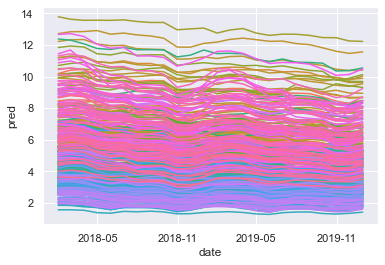

In [71]:
g = sns.lineplot(data=df, x="date", y="pred",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

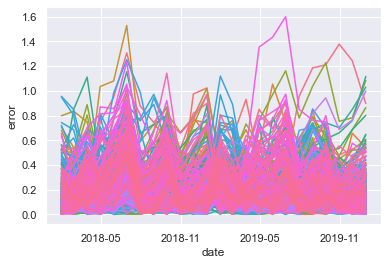

In [72]:
g = sns.lineplot(data=df, x="date", y="error",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

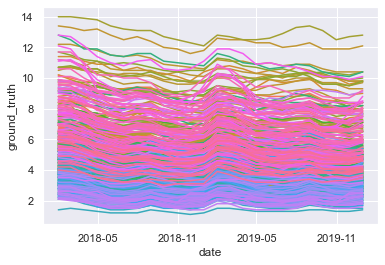

In [73]:
g = sns.lineplot(data=df, x="date", y="ground_truth",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

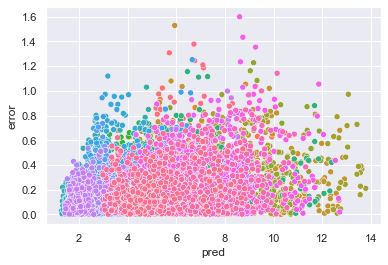

In [74]:
g = sns.scatterplot(data=df, x="pred", y="error",  hue="ags5")
g.legend_.remove()

## Plot sample to compare prediction to ground truth

In [75]:
df_long = df.melt(id_vars=['date','ags5','ags2','bundesland','kreis'], var_name='y_type', value_name='vals')

In [76]:
df_long = df_long[df_long['y_type'].isin(['ground_truth','pred'])]

In [147]:
sample_args = random.sample(list(set(df_long['ags5'])), 30)
df_sample = df_long[df_long['ags5'].isin(sample_args)]

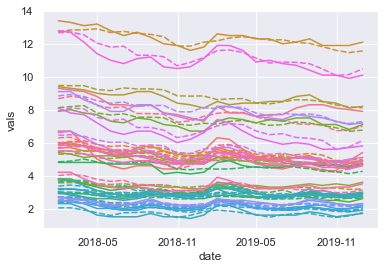

In [148]:
g = sns.lineplot(data=df_sample, x="date", y="vals",  hue="ags5", style="y_type")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

## Look into mean errors

In [79]:
df_mean_error = df.groupby(['ags5','ags2','bundesland','kreis']).mean()
df_mean_error              

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
01001,01,Schleswig-Holstein,"Flensburg, Stadt",8.137500,7.654453,0.514029
01002,01,Schleswig-Holstein,"Kiel, Landeshauptstadt",7.883333,8.146062,0.290269
01003,01,Schleswig-Holstein,"Lübeck, Hansestadt",7.525000,7.730177,0.235069
01004,01,Schleswig-Holstein,"Neumünster, Stadt",8.125000,8.292714,0.222192
01051,01,Schleswig-Holstein,Dithmarschen,5.887500,6.134025,0.393344
...,...,...,...,...,...,...
16073,16,Thüringen,Saalfeld-Rudolstadt,5.375000,5.428801,0.160927
16074,16,Thüringen,Saale-Holzland-Kreis,4.329167,4.451131,0.149345
16075,16,Thüringen,Saale-Orla-Kreis,4.733333,4.771823,0.176683


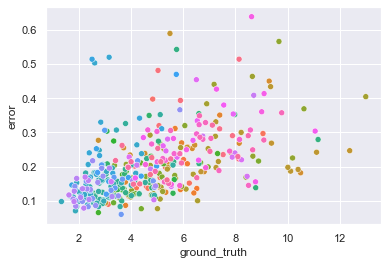

In [80]:
g = sns.scatterplot(data=df_mean_error, x="ground_truth", y="error",  hue="ags5")
g.legend_.remove()

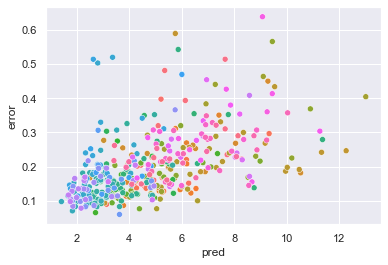

In [81]:
g = sns.scatterplot(data=df_mean_error, x="pred", y="error",  hue="ags5")
g.legend_.remove()

In [149]:
df_mean_error.sort_values(by = ['error'], ascending=False)

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
09562,09,Freistaat Bayern,Erlangen,3.616667,3.619546,0.060287
06631,06,Hessen,Fulda,2.741667,2.704146,0.065489
09175,09,Freistaat Bayern,Ebersberg,1.862500,1.821620,0.070578
06432,06,Hessen,Darmstadt-Dieburg,4.387500,4.381284,0.076734
05366,05,Nordrhein-Westfalen,Euskirchen,5.008333,5.039858,0.076856
...,...,...,...,...,...,...
09276,09,Freistaat Bayern,Regen,3.154167,3.355386,0.519725
07320,07,Rheinland-Pfalz,Stadt Zweibrücken,5.741667,5.861919,0.542494
05914,05,Nordrhein-Westfalen,Hagen,9.666667,9.456875,0.565753


<AxesSubplot:xlabel='error', ylabel='Density'>

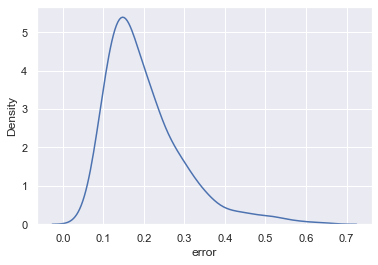

In [83]:
sns.kdeplot(data=df_mean_error, x="error", common_norm=False)

## Look into errors

In [151]:
df.sort_values(by = ['error'], ascending=False)

,,,,,ground_truth,pred,error,diff_ground_truth,diff_ground_truth_abs
ags5,ags2,date,bundesland,kreis,,,,,
09780,09,2018-04-30,Freistaat Bayern,Oberallgäu,2.6,2.600005,0.000005,0.1,0.1
07137,07,2019-03-31,Rheinland-Pfalz,Mayen-Koblenz,3.4,3.400010,0.000010,-0.2,0.2
09184,09,2019-07-31,Freistaat Bayern,München,2.2,2.200044,0.000044,0.1,0.1
08335,08,2019-05-31,Baden-Württemberg,Konstanz,2.9,2.899908,0.000092,0.0,0.0
08121,08,2018-05-31,Baden-Württemberg,Heilbronn,4.9,4.900155,0.000155,-0.1,0.1
...,...,...,...,...,...,...,...,...,...
13073,13,2019-04-30,Mecklenburg-Vorpommern,Vorpommern-Rügen,7.9,9.253987,1.353987,-1.6,1.6
01001,01,2019-10-31,Schleswig-Holstein,"Flensburg, Stadt",8.1,6.721840,1.378160,-0.2,0.2
13073,13,2019-05-31,Mecklenburg-Vorpommern,Vorpommern-Rügen,7.3,8.733983,1.433983,-0.6,0.6


In [85]:
df['diff_ground_truth'] = df.groupby('ags5')['ground_truth'].diff(1) 
df['diff_ground_truth_abs'] = df['diff_ground_truth'].abs()

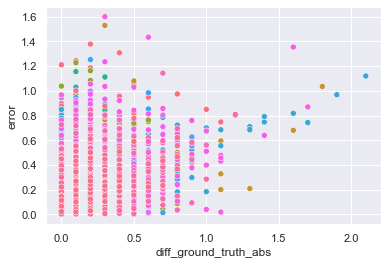

In [86]:
g = sns.scatterplot(data=df, x="diff_ground_truth_abs", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='error', ylabel='Density'>

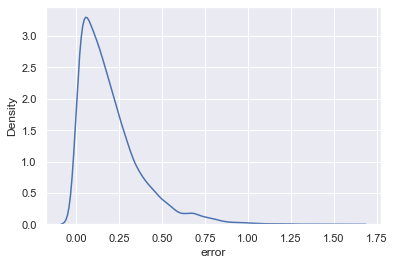

In [87]:
sns.kdeplot(data=df, x="error", common_norm=False)

<AxesSubplot:xlabel='error', ylabel='Density'>

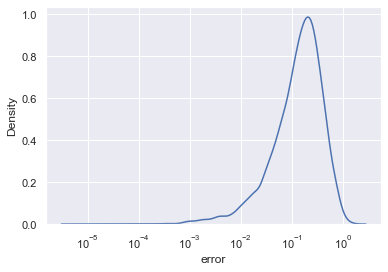

In [88]:
sns.kdeplot(data=df, x="error", common_norm=False,log_scale=True)

# Load structural data

In [117]:
df_structural = pd.read_csv('./../final_dfs/for_modeling/df_final_stationery.csv', converters={'ags2': str, 'ags5': str} )
df_structural = pd.merge(df_structural, df[['ags5','bundesland']])

### Merge to df with mean errors

In [119]:
df_mixed = pd.merge(df_mean_error, df_structural, on = ['ags5','ags2'])
df_mixed['bundesland'] = df_mixed['bundesland'].astype('category')
list(df_mixed.columns)

['ags5',
 'ags2',
 'ground_truth',
 'pred',
 'error',
 'cluster',
 'kreis',
 'supermarkets_population',
 'supermarkets_average_distance',
 'public_transport_availability',
 'average_distance_bus_stop',
 'average_distance_train_station',
 'average_distance_public_transport',
 'Unnamed:_0',
 'number_of_students',
 'number_of_hospitals',
 'number_of_hospital_beds',
 'number_of_hospital_beds_adj',
 'hospital_patiants',
 'households_of_1_person',
 'households_of_2_person',
 'households_of_3_person',
 'households_of_4_person',
 'households_of_5_person_or_more',
 'household_with_kids',
 'household_with_kids_under_3',
 'household_with_kids_over_3_under_6',
 'household_with_kids_over_6_under_10',
 'household_with_kids_over_10_under_15',
 'household_with_kids_over_15_under_18',
 'household_with_double_income_no_kids',
 'car_density',
 'no_of_paths_per_person_and_day',
 'kilometers_per_person_and_day',
 '_percentage_out_of_home',
 'share_of_journeys_on_foot',
 'share_of_journeys_on_bike',
 'propo

### Compare error in two_groups

In [91]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    plt.show()
    df[column_name] = df[column_name].astype(str)
    one, two = list(set(df[column_name]))
    df_one = df[df[column_name]==one]
    df_two = df[df[column_name]==two]
    return ttest_ind(df_one['error'], df_two['error'], equal_var=False)

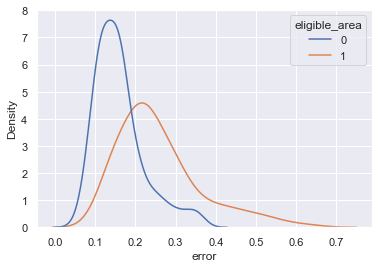

Ttest_indResult(statistic=10.88453967583672, pvalue=6.6404363018331e-23)

In [92]:
compare_error_in_two_groups(df_mixed, 'eligible_area')

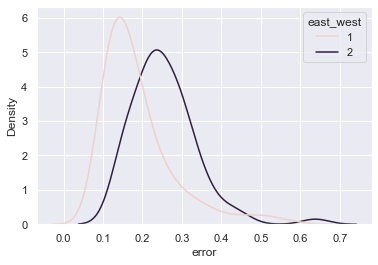

Ttest_indResult(statistic=-6.157566993146951, pvalue=8.955862206180588e-09)

In [93]:
compare_error_in_two_groups(df_mixed, 'east_west')

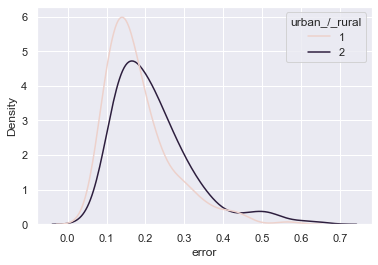

Ttest_indResult(statistic=-4.074555326786926, pvalue=5.585027887494875e-05)

In [94]:
compare_error_in_two_groups(df_mixed, 'urban_/_rural')

### Compare compare error in multiple groups

In [95]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    plt.show()
    mod = ols(f'error ~ {column_name}',
                data=df).fit()
                
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print(aov_table)

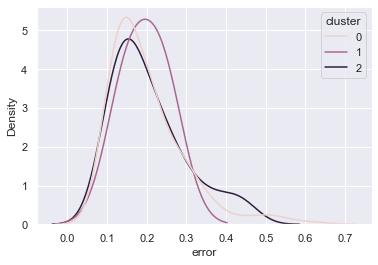

            sum_sq     df         F    PR(>F)
cluster   0.001842    1.0  0.200412  0.654632
Residual  3.667958  399.0       NaN       NaN


In [96]:
compare_error_in_two_groups(df_mixed, "cluster")

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


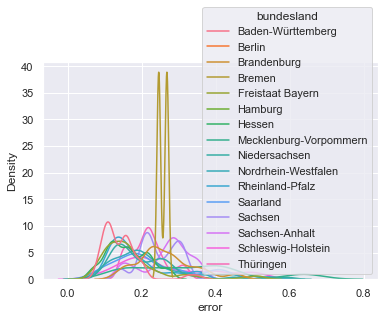

               sum_sq      df           F  PR(>F)
bundesland  15.825688    15.0  140.303779     0.0
Residual    72.249520  9608.0         NaN     NaN


In [120]:
compare_error_in_two_groups(df_mixed, "bundesland")

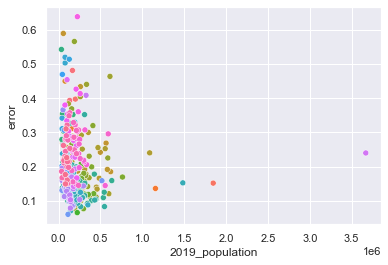

In [98]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

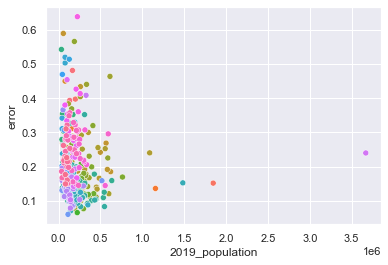

In [99]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

### Linear Regression

In [100]:
df_mixed.set_index('ags5', drop=True, inplace=True)

In [101]:
df_mixed['east_west'] = df_mixed['east_west'].astype(str)
df_mixed['eligible_area'] = df_mixed['eligible_area'].astype(str)
df_mixed['cluster'] = df_mixed['cluster'].astype(str)
df_mixed['urban_/_rural'] = df_mixed['urban_/_rural'].astype(str)

X = df_mixed.drop(['kreis','pred','error','ground_truth','Unnamed:_0'], axis=1)
Y = np.log(df_mixed['error'])

X = pd.get_dummies(data=X, drop_first=True)

In [102]:
regr = LinearRegression()
regr.fit(X, Y, sample_weight=None)

LinearRegression()

In [103]:
stats.summary(regr, X, Y, X.columns)

Residuals:
    Min     1Q  Median     3Q    Max
-0.5827 -0.132 -0.0017 0.1451 0.8126


Coefficients:
                                                   Estimate                  Std. Error          t value   p value
_intercept                                       -99.703028  2.554331e+05+1.300000e-05j  -0.0004+0.0000j  0.999689
supermarkets_population                            0.003391  4.659000e-03+5.223000e-03j   0.3225-0.3615j  0.628335
supermarkets_average_distance                      0.000030  8.000000e-05+1.444000e-03j   0.0012-0.0209j  0.983275
public_transport_availability                      0.002071  1.693000e-03+4.820000e-04j   1.1313-0.3217j  0.240228
average_distance_bus_stop                          0.000350  1.830000e-04+1.500000e-05j   1.8944-0.1590j  0.058008
average_distance_train_station                     0.000034  8.400000e-05+1.800000e-05j   0.3826-0.0825j  0.695746
average_distance_public_transport                 -0.000593  2.490000e-04+4.700000e-05j  -2.30

### Sequential Feature Selector

In [104]:
sfs1 = sfs(regr, k_features = 10,forward=True, floating=False, scoring='r2', cv=5)
sfs1.fit(X, Y)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=10,
                          scoring='r2')

In [105]:
summary_table_select = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
summary_table_select

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(150,)","[0.17543331977188426, 0.14102970031853357, 0.2...",0.156636,"(purchasing_power_per_household,)",0.083824,0.065218,0.032609
2,"(150, 196)","[0.19521551714881924, 0.213935805379583, 0.279...",0.215018,"(purchasing_power_per_household, eligible_area_1)",0.094575,0.073583,0.036791
3,"(33, 150, 196)","[0.22294822684724835, 0.24723029176994615, 0.3...",0.23762,"(activity_index, purchasing_power_per_househol...",0.113355,0.088194,0.044097
4,"(33, 77, 150, 196)","[0.27976188410343406, 0.22297004259335285, 0.2...",0.256074,"(activity_index, number_accomodation_establish...",0.078038,0.060716,0.030358
5,"(33, 77, 119, 150, 196)","[0.32572864596760354, 0.23650686884415983, 0.3...",0.275925,"(activity_index, number_accomodation_establish...",0.091387,0.071102,0.035551
6,"(33, 77, 119, 150, 152, 196)","[0.31148829801300104, 0.2806127074162643, 0.38...",0.294389,"(activity_index, number_accomodation_establish...",0.090648,0.070527,0.035263
7,"(33, 77, 119, 150, 152, 193, 196)","[0.3846631147645784, 0.31215120487649795, 0.37...",0.318909,"(activity_index, number_accomodation_establish...",0.098607,0.07672,0.03836
8,"(33, 77, 119, 150, 152, 187, 193, 196)","[0.39200598176115653, 0.287427112242124, 0.413...",0.336854,"(activity_index, number_accomodation_establish...",0.110234,0.085766,0.042883
9,"(33, 77, 119, 150, 152, 173, 187, 193, 196)","[0.4213859716373578, 0.3144698966946371, 0.401...",0.349842,"(activity_index, number_accomodation_establish...",0.103135,0.080243,0.040121
10,"(33, 77, 78, 119, 150, 152, 173, 187, 193, 196)","[0.416271101588085, 0.32567932289889656, 0.401...",0.360842,"(activity_index, number_accomodation_establish...",0.084322,0.065605,0.032803


In [106]:
list(summary_table_select['feature_names'])[:5]

[('purchasing_power_per_household',),
 ('purchasing_power_per_household', 'eligible_area_1'),
 ('activity_index', 'purchasing_power_per_household', 'eligible_area_1'),
 ('activity_index',
  'number_accomodation_establishments',
  'purchasing_power_per_household',
  'eligible_area_1'),
 ('activity_index',
  'number_accomodation_establishments',
  'no_of_public_institution',
  'purchasing_power_per_household',
  'eligible_area_1')]

### Ridge

In [107]:
rr = Ridge(alpha=0.5) 
rr.fit(X, Y)

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.95493e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Ridge(alpha=0.5)

In [108]:
stats.summary(rr, X, Y, X.columns)

Residuals:
    Min      1Q  Median     3Q    Max
-0.5766 -0.1422 -0.0013 0.1469 0.8604


Coefficients:
                                                   Estimate                  Std. Error         t value   p value
_intercept                                       -17.806413  2.618670e+05+1.300000e-05j -0.0001+0.0000j  0.999946
supermarkets_population                            0.001288  3.313000e-03+4.780000e-03j  0.1262-0.1821j  0.824806
supermarkets_average_distance                      0.000034  7.650000e-04+1.039000e-03j  0.0158-0.0215j  0.978711
public_transport_availability                     -0.000332  2.851000e-03-1.010000e-04j -0.1164-0.0041j  0.907332
average_distance_bus_stop                          0.000396  2.030000e-04+6.000000e-06j  1.9498-0.0549j  0.051810
average_distance_train_station                     0.000022  4.700000e-05+0.000000e+00j  0.4639-0.0025j  0.642939
average_distance_public_transport                 -0.000636  3.870000e-04+4.000000e-06j -1.6419+0.0

household_with_kids  
public_transport_per_1000_inhabitants 
number_of_companies_repair_motor_vehicles 
number_of_companies_hospitality
number_of_companies_technical_services
debtor_quota
purchasing_power_per_household

## Look at the variables that are important for predicting the error

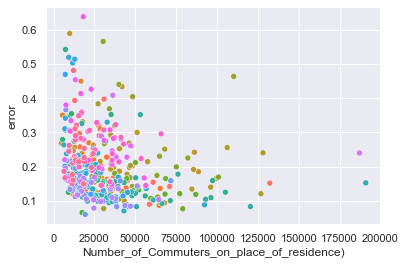

In [109]:
g = sns.scatterplot(data=df_mixed, x="Number_of_Commuters_on_place_of_residence)", y="error",  hue="ags5")
g.legend_.remove()

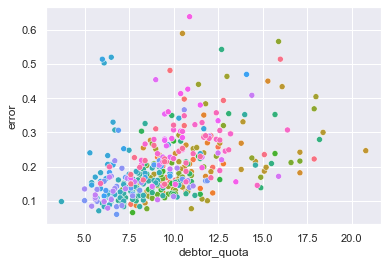

In [110]:
g = sns.scatterplot(data=df_mixed, x="debtor_quota", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='debtor_quota', ylabel='Density'>

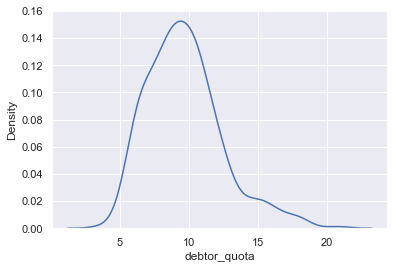

In [111]:
sns.kdeplot(data=df_mixed, x="debtor_quota", common_norm=False)

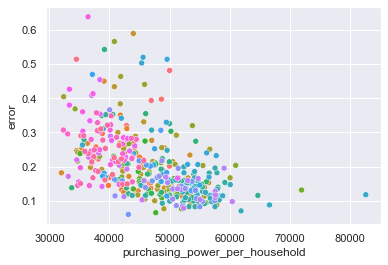

In [112]:
g = sns.scatterplot(data=df_mixed, x="purchasing_power_per_household", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='purchasing_power_per_household', ylabel='Density'>

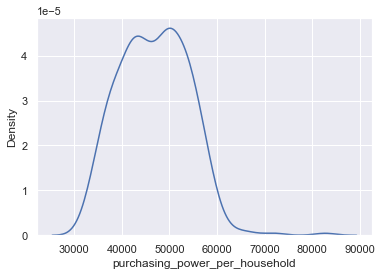

In [113]:
sns.kdeplot(data=df_mixed, x="purchasing_power_per_household", common_norm=False)

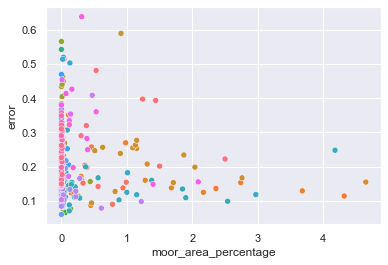

In [114]:
g = sns.scatterplot(data=df_mixed, x="moor_area_percentage", y="error",  hue="ags5")
g.legend_.remove()